# Face Mask Detection and Social Distancing
<br>Table of Contents (Unfinished): 

* [Prerequisites](#1)
    * [Installing the Dependencies](#2)
    * [Loading the Dataset](#3)
* [Face detection and social distancing detection](#4)
    * [Using Haarcascades to Detect Faces](#5)


<a id="1"></a>
## Prerequisites

<a id="2"> </a>
### Installing the Dependencies

In [2]:
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install imutils
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install pillow

In [3]:
# Keras imports
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from keras.utils import img_to_array, load_img
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image


# # sklearn imports
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# # imutils imports
from imutils import paths

# # misc
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os
import cv2

from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

<a id="3"> </a>
### Loading the Data Set

In [4]:
# Directory structure
# CS180-MASKPATROL    
# |__.venv
# |__datasets
# |       |__FMD-SD
# |       |     |__Face Mask Detection
# |       |     |       |__ annotations
# |       |     |       |__ images
# |       |     |__Haarcascades
# |       |__MaskedFace-Net
# |             |__NM
# |             |__CMFD
# |             |   |__00000
# |             |   |__01000
# |             |   |__ ...
# |             |   |__60000
# |             |__IMFD
# |                 |__00000
# |                 |__01000
# |                 |__ ...
# |                 |__60000
# |__mask-detection.ipnyb
# |__README.me

In [5]:
# folder_path = os.path.join(os.getcwd(), "datasets/FMD-SD")

# for dirname, _, filenames in os.walk(folder_path):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# Face Detection and Social Distancing Detection

Constructing the Face Model using Haarcascade

In [6]:
# getting the haarcascade_path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
haarcascade_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Haarcascades', 'haarcascade_frontalface_default.xml')  # Specify the relative path to the image file

# constructing the face_model
face_model = cv2.CascadeClassifier(haarcascade_path)

Testing the Face Model

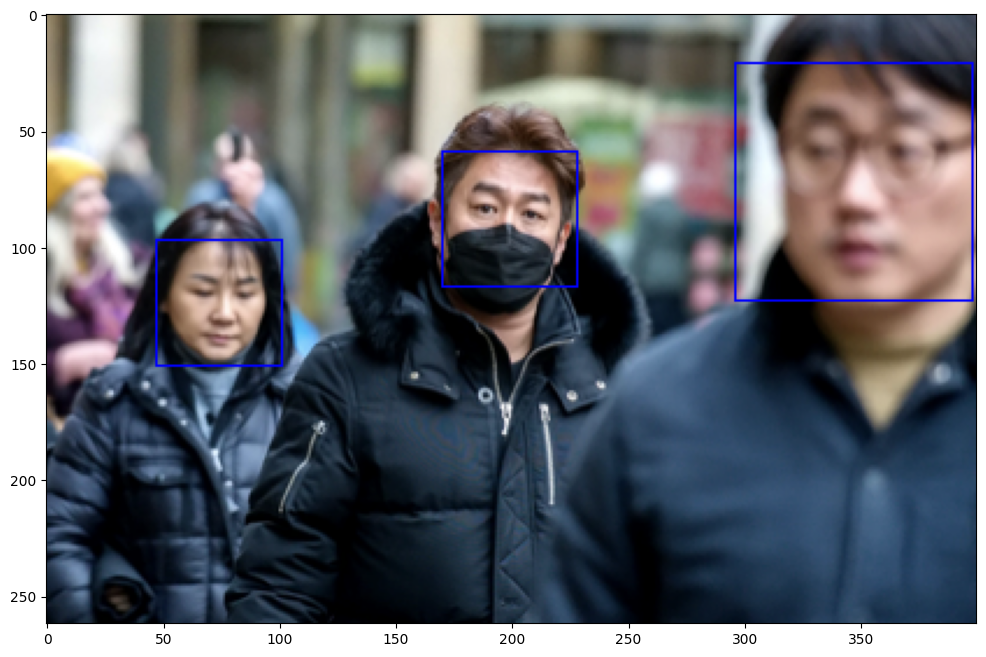

In [76]:
# extract faces from an image and draw rectangles to mark them
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Face Mask Detection', 'images', 'maksssksksss244.png') # Specify the relative path to the image file

# reading and preprocessing the image
img = cv2.imread(image_path) # Read the image using cv2.imread()
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # coloring the image

# detecting the faces in the image using face_model
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting the rectangles on the faces from the face_model
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

# show the plot on an image
plt.figure(figsize=(12,12))
plt.imshow(out_img)


Testing Social Distancing Violations

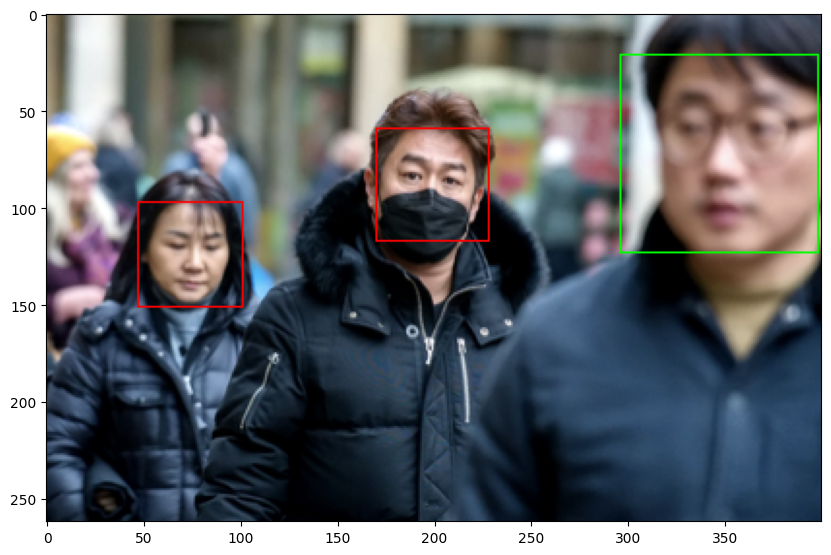

In [8]:
MIN_DISTANCE = 130

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

# Face Mask Detector

Load the images into image arrays

In [18]:
# load the images into image arrays
data = []
labels = []

# getting the path of the cmfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'CMFD') # Specify the relative path to the cmfd folder

# loading the cmfd images into data and labels
for folder in os.listdir(dir_path):
    new_dir = os.path.join(dir_path,folder) 
    # print(new_dir)
    for img in os.listdir(new_dir):
        img_path = os.path.join(new_dir,img)               #obtain the image path
        image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
        image = img_to_array(image)                         #convert the image to an array
        image = preprocess_input(image)                     #ensure that the image is transformed for the model

        data.append(image)                                  #store the image as an array in data
        labels.append(0)                                    #images are labelled 0 for "CMFD" or "With Mask"

    print(len(data))

950
1912
2862
3815
4784
5758


In [19]:
# getting the path of the imfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'IMFD') # Specify the relative path to the imfd folder

# loading the imfd images into data and labels
label = ""

for folder in os.listdir(dir_path):
    new_dir = os.path.join(dir_path,folder)
    # print(new_dir)
    for img in os.listdir(new_dir):
        
        # assigning the label for each image
        if "Nose" not in img and "Mouth" not in img:
            label=3                                         #label 3 for "IMFD3" or "Uncovered Nose and Mouth"
        elif "Chin" not in img:
            label=1                                         #label 1 for "IMFD1" or "Uncovered Chin"
        elif "Nose" not in img:
            label=2                                         #label 2 for "IMFD2" or "Uncovered Nose"

        img_path = os.path.join(new_dir,img)               #obtain the image path
        image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
        image = img_to_array(image)                         #convert the image to an array
        image = preprocess_input(image)                     #ensure that the image is transformed for the model

        data.append(image)                                  #store the image as an array in data
        labels.append(label)                                #store thelabel obtained

    print(len(data))

6686
7641
8602
9569
10535
11495


In [20]:
# getting the path of the NM 
base_dir = os.path.dirname(os.path.abspath('__file__'))                     # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'NM')       # Specify the relative path to the NM folder

# loading the cmfd images into data and labels
for img in os.listdir(dir_path):
    img_path = os.path.join(dir_path,img)               #obtain the image path
    image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
    image = img_to_array(image)                         #convert the image to an array
    image = preprocess_input(image)                     #ensure that the image is transformed for the model
    data.append(image)                                  #store the image as an array in data
    labels.append(4)                                    #images are labelled 0 for "NM" or "No Mask"

print(len(data))


17404


Perform one-hot encoding on the labels

In [21]:
# convert labels to arrays
# for instance, 0 = [1, 0, 0, 0], 1 = [0, 1, 0, 0] and so on
 
labels = to_categorical(labels)
# print(labels)

In [22]:
# convert data and labels to NumPy arrays to ensure that elements are represented as 32-bit floating point numbers

data=np.array(data, dtype="float32")
labels=np.array(labels)

In [23]:
print(data.shape)

(17404, 224, 224, 3)


<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 20%.
* train size is 80%.

In [24]:
data.shape

(17404, 224, 224, 3)

In [26]:
# Split the data and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13923, 224, 224, 3)
X_test shape: (3481, 224, 224, 3)
y_train shape: (13923, 5)
y_test shape: (3481, 5)


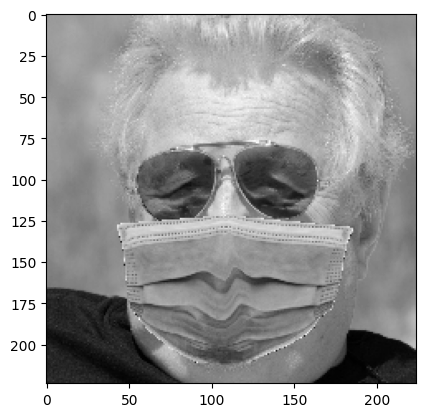

In [27]:
# Show a sample of a train image
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 

In [28]:
# instantiate values of learning rate, epoch, and batch size
lr = 1e-4 
epoch = 10
bs = 32 

# make the base model using MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",                                         #initialize base_model with pre-trained weights from ImageNet dataset
    include_top=False,                                          #only create the base model as a feature extractor
    input_tensor=Input(shape=(224,224,3))                       #the model expects 224 x 224 images with 3 color channels
)

# constructing the head model
head_model = base_model.output                                  #aligns head_model to the output of the base_model
head_model = AveragePooling2D(pool_size=(7,7))(head_model)      #perform spatial pooling and reduce spatial dimensions of the extracted features with a 7x7 pooling window size
head_model = Flatten(name="flatten")(head_model)                #convert the output to a 1d vector
head_model = Dense(128, activation="relu")(head_model)          #add a dense layer with 128 units and relu activation to learn non-linear relationships
head_model = Dropout(0.5)(head_model)                           #prevent overfitting
head_model = Dense(5, activation="softmax")(head_model)         #convert the output to a probability distribution over the 5 classes (aka the predictions)

In [30]:
#new model with the inputs being the input of base_model and the output being the head_model

model = Model(inputs=base_model.input, outputs=head_model)

In [31]:
#freeze the layers for training 
for layer in base_model.layers:
    layer.trainable = False

In [32]:
#compile the model
opt = Adam(lr=lr, decay=lr/epoch)           #use the Adam optimizer for keras 
model.compile(
    loss="categorical_crossentropy",        #the loss function is the categorical cross-entropy loss bc there are multiple classes
    optimizer=opt,
    metrics=["accuracy"]
)

In [33]:
#augment the images to create more variations for training
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [43]:
#train the model using a data generator 

history = model.fit_generator(
    aug.flow(X_train,y_train, batch_size=bs),
    epochs = epoch, 
    validation_data = (X_test,y_test), 
    validation_steps=len(X_test) // bs,
    steps_per_epoch=len(X_train) // bs
    )

Epoch 1/10
435/435 [==============================] - 260s 597ms/step - loss: 0.4049 - accuracy: 0.8688 - val_loss: 0.2010 - val_accuracy: 0.9290
Epoch 2/10
435/435 [==============================] - 210s 481ms/step - loss: 0.2128 - accuracy: 0.9279
Epoch 3/10
435/435 [==============================] - 205s 472ms/step - loss: 0.1616 - accuracy: 0.9424
Epoch 4/10
435/435 [==============================] - 208s 477ms/step - loss: 0.1389 - accuracy: 0.9521
Epoch 5/10
435/435 [==============================] - 210s 483ms/step - loss: 0.1226 - accuracy: 0.9576
Epoch 6/10
435/435 [==============================] - 203s 467ms/step - loss: 0.1102 - accuracy: 0.9625
Epoch 7/10
435/435 [==============================] - 201s 461ms/step - loss: 0.1019 - accuracy: 0.9647
Epoch 8/10
435/435 [==============================] - 199s 457ms/step - loss: 0.0926 - accuracy: 0.9665
Epoch 9/10
435/435 [==============================] - 204s 469ms/step - loss: 0.0872 - accuracy: 0.9703
Epoch 10/10
435/435 [=

## Predicting using the Model

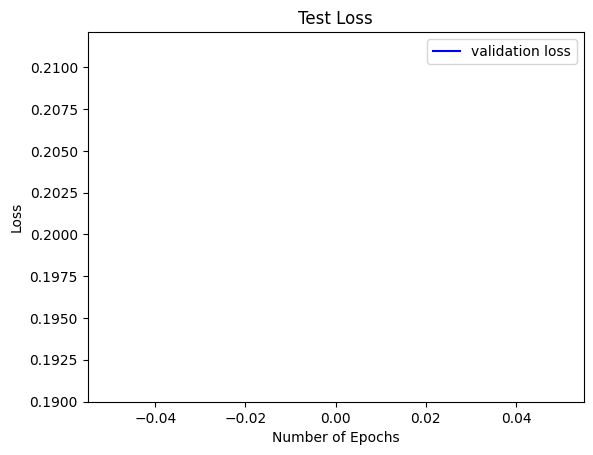

In [53]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [45]:
#predict results of the model 
y_pred = model.predict(X_test, batch_size=bs)

109/109 [==============================] - 45s 413ms/step


In [46]:
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [47]:
print(y_pred)
print(y_test_labels)

[4 2 4 ... 0 4 4]
[4 2 4 ... 0 4 4]


In [48]:
#observe model prediction results
print(classification_report(
    y_test_labels,
    y_pred
))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1155
           1       0.80      0.92      0.86       106
           2       0.97      0.97      0.97       985
           3       0.94      0.75      0.84        89
           4       1.00      1.00      1.00      1146

    accuracy                           0.98      3481
   macro avg       0.94      0.93      0.93      3481
weighted avg       0.98      0.98      0.98      3481



## Test Model on the Test Data

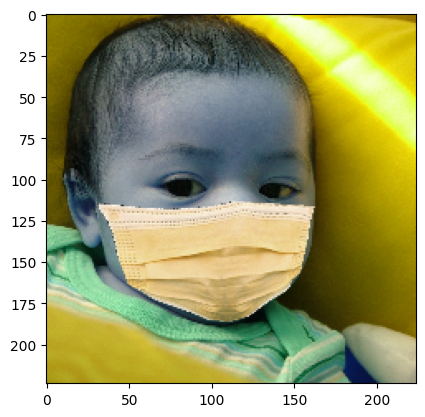

In [58]:
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'CMFD', '00000', '00000_Mask.jpg') # Specify the relative path to the image file

sample_mask_img = cv2.imread(image_path)
sample_mask_img = cv2.resize(sample_mask_img,(224,224))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,224,224,3])
sample_mask_img = sample_mask_img

In [59]:
mask_label = {0:'MASK', 1:'UNCOVERED CHIN', 2:'UNCOVERED NOSE', 3:'UNCOVERED NOSE AND MOUTH', 4:"NO MASK"}
dist_label = {0:(0,255,0),1:(255,0,0)}

1/1 [==============================] - 0s 31ms/step


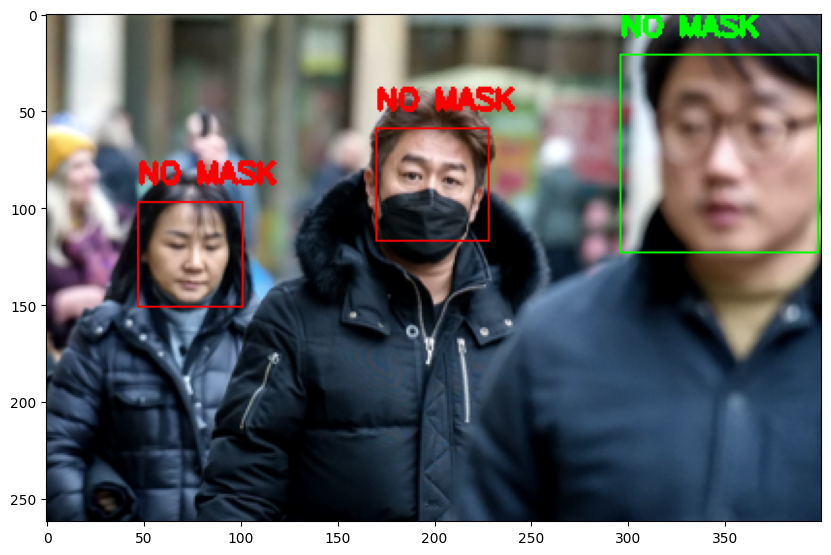

In [78]:
# extract faces from an image and draw rectangles to mark them
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Face Mask Detection', 'images', 'maksssksksss244.png') # Specify the relative path to the image file

# reading and preprocessing the image
img = cv2.imread(image_path) # Read the image using cv2.imread()
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # coloring the image

# detecting the faces in the image using face_model
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting the rectangles on the faces from the face_model
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(224,224))
        crop = np.reshape(crop,[1,224,224,3])
        mask_result = model.predict(crop, batch_size=bs)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")